<a href="https://colab.research.google.com/github/arakskarapetyan/Business_Analytics_2020/blob/master/Business_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import time
import numpy as np
import itertools
from pandas import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Importing the dataframe
url = "https://raw.githubusercontent.com/arakskarapetyan/Business_Analytics_2020/master/Armenia_COVID_Cases.csv"
data = pd.read_csv(url, index_col = 'Date', parse_dates = True)

In [0]:
data.head()

,iso_code,Country_Region,NewCases,Confirmed Cases,NewDeaths,TotalDeaths
Date,,,,,,
2020-03-01,ARM,Armenia,1,1,0,0
2020-03-02,ARM,Armenia,0,1,0,0
2020-03-03,ARM,Armenia,0,1,0,0
2020-03-04,ARM,Armenia,0,1,0,0
2020-03-05,ARM,Armenia,0,1,0,0


In [0]:
data.tail()

,iso_code,Country_Region,NewCases,Confirmed Cases,NewDeaths,TotalDeaths
Date,,,,,,
2020-05-10,ARM,Armenia,79,3392,1,46
2020-05-11,ARM,Armenia,146,3538,1,47
2020-05-12,ARM,Armenia,180,3718,1,48
2020-05-13,ARM,Armenia,142,3860,1,49
2020-05-14,ARM,Armenia,184,4044,3,52


In [0]:
data.rename(columns={'Confirmed Cases':'ConfirmedCases'},inplace=True)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 2020-03-01 to 2020-05-14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso_code        75 non-null     object
 1   Country_Region  75 non-null     object
 2   NewCases        75 non-null     int64 
 3   ConfirmedCases  75 non-null     int64 
 4   NewDeaths       75 non-null     int64 
 5   TotalDeaths     75 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 4.1+ KB


In [0]:
data.shape

(75, 6)

In [0]:
#The following command gives us basic summary statistics. It shows that the maximum number of new recorded cases is 184, which was May 14, 2020.
#It also shows that Armenia has total of 52 death cases, which is trivial when we compare it to the world numbers. 
data.describe()

,NewCases,ConfirmedCases,NewDeaths,TotalDeaths
count,75.000000,75.000000,75.000000,75.000000
mean,53.920000,1148.026667,0.693333,15.560000
std,48.398336,1137.691914,0.914941,16.698632
min,0.000000,1.000000,0.000000,0.000000
25%,18.500000,148.000000,0.000000,0.000000
50%,43.000000,881.000000,0.000000,9.000000
75%,73.000000,1777.000000,1.000000,28.500000
max,184.000000,4044.000000,4.000000,52.000000


Identification - data manipulation, transformation

Text(0.5, 1.0, 'The Growth of COVID-19 Cases in Armenia (daily)')

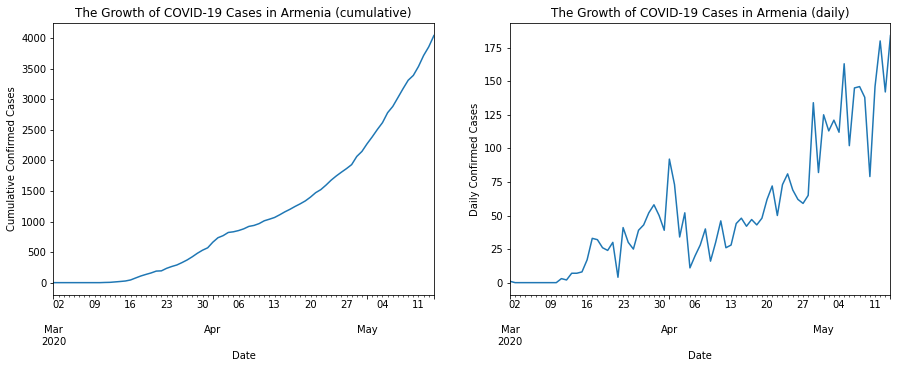

In [0]:
#Plotting the data of Confirmed cases: it is visible that the data has a trend as it is growing.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data['ConfirmedCases'].plot()
plt.ylabel('Cumulative Confirmed Cases')
plt.title('The Growth of COVID-19 Cases in Armenia (cumulative)')

plt.subplot(1,2,2)
data['NewCases'].plot()
plt.ylabel('Daily Confirmed Cases')
plt.title('The Growth of COVID-19 Cases in Armenia (daily)')


In [0]:
#Calculating the autocorrelation. It seems that the cases have high correlation with the lagged copy.
data['ConfirmedCases'].autocorr()

0.9998395443000888

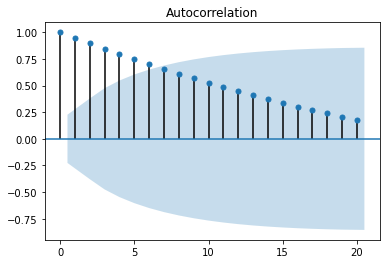

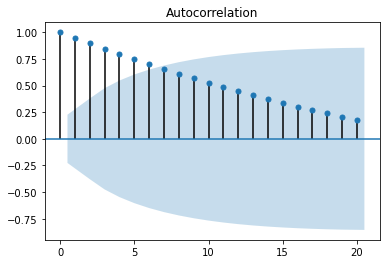

In [0]:
#Plotting the autocorrelation to see if there is a correlation between confirmed cases and the lagged copy of itself. The plot shows high autocorrelation. 
plot_acf(data.ConfirmedCases, lags = 20, alpha = 0.05)

In [0]:
#Running the adfuller test to see if the series is random walk. The null is that the series is random walk/non-stationary.
results = adfuller(data['ConfirmedCases'])

In [0]:
#The p-value is 1.0, which means we fail to reject the null. 
print(results)

(2.7445814553103896, 1.0, 5, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, 558.2635932049561)


In [0]:
#To make the data stationary let's take the first difference of the series.
data['data_diff1'] = data.ConfirmedCases.diff(periods = 1)

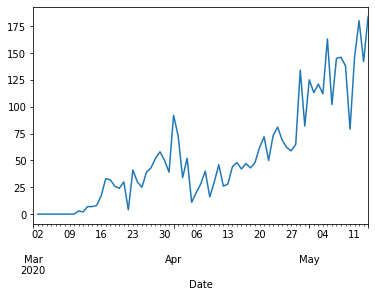

In [0]:
#We can observe from the plot that it still has a trend and is not stationary.
data.data_diff1.plot()

In [0]:
#Let's take the 2nd difference.
data['data_diff2'] = data.data_diff1.diff(periods = 1)

In [0]:
data = data.dropna()

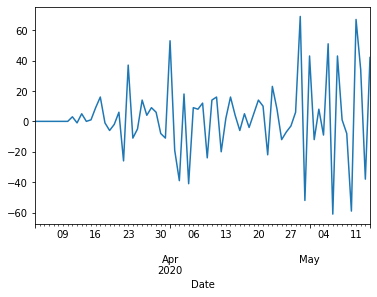

In [0]:
#We can see that it became stationary.
data.data_diff2.plot()

In [0]:
#We run the test again.
results1 = adfuller(data['data_diff2'])

In [0]:
#The p-value became very small, now we can surely reject the null.
print(results1[1])

0.00011164420571184414


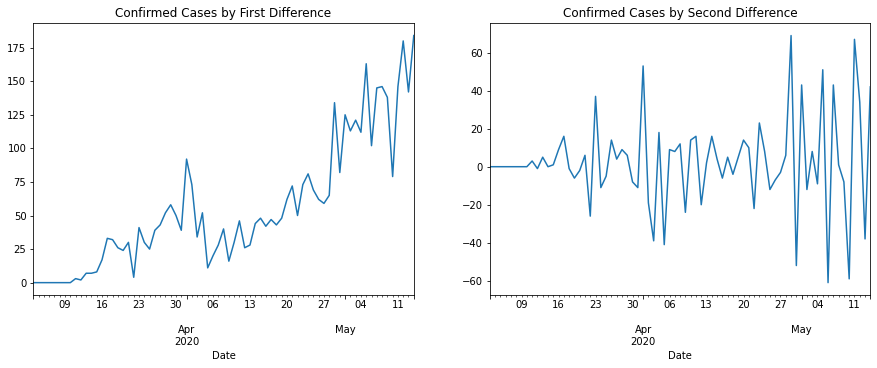

In [0]:
#Let's create a subplot of the two versions
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data.data_diff1.plot()
plt.title('Confirmed Cases by First Difference')

plt.subplot(1,2,2)
data.data_diff2.plot()
plt.title('Confirmed Cases by Second Difference')
plt.show()

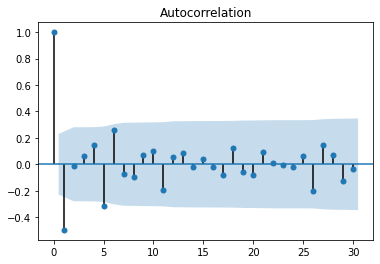

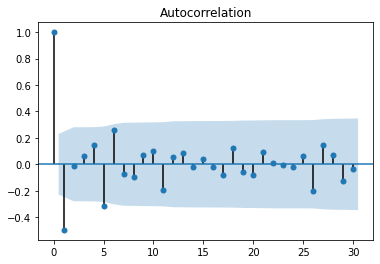

In [0]:
#Plotting the autocorrelation after making the data stationary.
plot_acf(data.data_diff2, lags = 30, alpha = 0.05)

In [0]:
data['ConfirmedCases'].size

73

Model estimation - ARIMA 

In [0]:
#p, d, q
#1. Number of AR (Auto-Regressive) terms (p).
#2. Number of I (Integrated or Difference) terms (d).
#3. Number of MA (Moving Average) terms (q)
arima = SARIMAX(data['ConfirmedCases'], order=(2,2,13))
arima_results=arima.fit()
print(arima_results.aic)
print(arima_results.bic)
print(arima_results.summary())

648.7023973577093
684.9052753903703
                           Statespace Model Results                           
Dep. Variable:         ConfirmedCases   No. Observations:                   73
Model:              SARIMAX(2, 2, 13)   Log Likelihood                -308.351
Date:                Fri, 15 May 2020   AIC                            648.702
Time:                        21:27:46   BIC                            684.905
Sample:                    03-03-2020   HQIC                           663.099
                         - 05-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5022      0.523     -0.960      0.337      -1.527       0.523
ar.L2         -0.3968      0.203     -1.956      0.050      -0.794       0.001
ma.L1         -0

In [0]:
#Assign residuals to variable
residuals=arima_results.resid
residuals

Date
2020-03-03     1.000000
2020-03-04    -0.500019
2020-03-05    -0.000289
2020-03-06    -0.000156
2020-03-07    -0.000066
                ...    
2020-05-10   -33.558374
2020-05-11     2.694933
2020-05-12    45.236336
2020-05-13    -5.119078
2020-05-14    20.126713
Length: 73, dtype: float64

In [0]:
#Calculating the mean absolute error
mae=np.mean(np.abs(residuals))
mae

12.89705866944545

In [0]:
#Calculating the mean absolute deviation
residuals.mad()

12.975773687307923

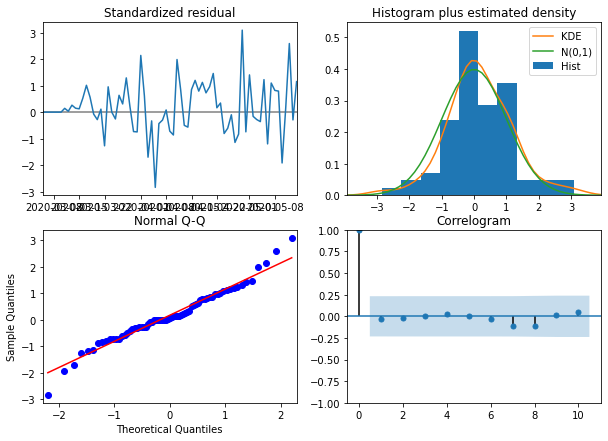

In [0]:
#Creat the 4 diagnostics plots
arima_results.plot_diagnostics(figsize=(10,7))
plt.show()
#The residuals plot shows no obvious pattern/structure.
#The histogram shows the measured distribution. A green line shows normal distribution, whereas the orange line shows the smoothed version of the histogram.
#If the model is good, those 2 lines should be almost the same.
#QQ plot is another way of showing how the distribution of the model resiudals compares to a normal distribution. We can see that most of the values lie along
#the red line (except some values at either end).
#Correlogram shows no correlation in the residuals.

Production - Making the Forecast

In [0]:
# Make ARIMA forecast of next 30 values
arima_value_forecast = arima_results.get_forecast(steps=30).predicted_mean

In [0]:
# Print forecast
print(arima_value_forecast)

2020-05-15    4213.349005
2020-05-16    4367.826990
2020-05-17    4535.161433
2020-05-18    4715.479092
2020-05-19    4872.843387
2020-05-20    5063.665865
2020-05-21    5260.967944
2020-05-22    5431.813015
2020-05-23    5596.147521
2020-05-24    5791.849772
2020-05-25    5990.985214
2020-05-26    6181.606819
2020-05-27    6384.267273
2020-05-28    6584.260607
2020-05-29    6780.815756
2020-05-30    6980.155976
2020-05-31    7179.461991
2020-06-01    7377.679934
2020-06-02    7576.457873
2020-06-03    7775.386386
2020-06-04    7974.017048
2020-06-05    8172.737534
2020-06-06    8371.531112
2020-06-07    8570.252337
2020-06-08    8768.980891
2020-06-09    8967.734478
2020-06-10    9166.472585
2020-06-11    9365.208532
2020-06-12    9563.951706
2020-06-13    9762.692108
Freq: D, dtype: float64


In [0]:
#Getting all the possible combinations of p,d,q
p = d = q = range(0,5) #We put whatever range we wish.
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [0]:
#The command gives the AIC for all combinations of p,d,q. The best(lowest) version is already chosen above. 
#However, our choice was not only based on the AIC score. It also takes into account the diagnostics and error metrics. 
for param in pdq:
    try:
        arima = SARIMAX(data.ConfirmedCases, order = param)
        arima_results = arima.fit()
        print(param,arima_results.aic)
    except:
        continue

(0, 0, 0) 1289.2836171652275
(0, 0, 1) 1197.4530924705648
(0, 0, 2) 1122.235804319966
(0, 0, 3) 1040.8763199158673
(0, 0, 4) 1030.0892666370064
(0, 1, 0) 825.5841087224925
(0, 1, 1) 772.4267042020215
(0, 1, 2) 739.6658778493047
(0, 1, 3) 716.6115548148698
(0, 1, 4) 705.584513780221
(0, 2, 0) 659.5300652122618
(0, 2, 1) 637.060354242711
(0, 2, 2) 637.0845181082962
(0, 2, 3) 638.4397935649805
(0, 2, 4) 640.4397037882991
(0, 3, 0) 726.4406244727888
(0, 3, 1) 656.7566124184611
(0, 3, 2) 630.6487012978001
(0, 3, 3) 631.9299710012689
(0, 3, 4) 633.8209502991695
(0, 4, 0) 798.2312030171897
(0, 4, 1) 723.2878527694231
(0, 4, 2) 658.3400886080568
(0, 4, 3) 635.2077485802605
(0, 4, 4) 636.4317558726348
(1, 0, 0) 846.3185504854297
(1, 0, 1) 793.1989523424081
(1, 0, 2) 760.4950845896616
(1, 0, 3) 736.8959328660957
(1, 0, 4) 731.1415405480149
(1, 1, 0) 672.6025145758705
(1, 1, 1) 651.1969732264549
(1, 1, 2) 651.249500410398
(1, 1, 3) 652.6329558452546
(1, 1, 4) 654.6329240961604
(1, 2, 0) 641.97965

#Facebook Prophet

In [0]:
#Now, let's use another approach for making a forecast. Facebook Prophet is a package, which is used for a forecast of time series data. 
#The unique thing about this package is that it automatically finds seasonal trends beneath the data and offers a solution. The aproach is a lot easier
#than ARIMA, also it provides better visualization tools.

In [0]:
#First let's store the data in a new dataframe to make it workable for Prophet.
data_= pd.read_csv(url)
data_
data_.rename(columns={'Confirmed Cases':'ConfirmedCases'},inplace=True)

In [0]:
#The input to Prophet should be two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. 
#The y column must be numeric, and represent the measurement we wish to forecast (in our case ConfirmedCases column).
data_.rename(columns={'Date':'ds', 'ConfirmedCases':'y'},inplace=True)
data_.head()

,iso_code,Country_Region,ds,NewCases,y,NewDeaths,TotalDeaths
0,ARM,Armenia,2020-03-01,1,1,0,0
1,ARM,Armenia,2020-03-02,0,1,0,0
2,ARM,Armenia,2020-03-03,0,1,0,0
3,ARM,Armenia,2020-03-04,0,1,0,0
4,ARM,Armenia,2020-03-05,0,1,0,0


In [0]:
#We are dropping the rest of the columns, because we do not need them. 
data_.drop(['NewCases', 'TotalDeaths', 'NewDeaths',], axis=1)

,iso_code,Country_Region,ds,y
0,ARM,Armenia,2020-03-01,1
1,ARM,Armenia,2020-03-02,1
2,ARM,Armenia,2020-03-03,1
3,ARM,Armenia,2020-03-04,1
4,ARM,Armenia,2020-03-05,1
...,...,...,...,...
70,ARM,Armenia,2020-05-10,3392
71,ARM,Armenia,2020-05-11,3538
72,ARM,Armenia,2020-05-12,3718
73,ARM,Armenia,2020-05-13,3860


In [0]:
#We are instantiating a new Prophet object and fitting it.
m = Prophet()
m.fit(data_)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
#We should create a dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.
#By default it will also include the dates from the history, so we will see the model fit as well, which is not the case for ARIMA.
#We have specified 30 days.
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
100,2020-06-09
101,2020-06-10
102,2020-06-11
103,2020-06-12
104,2020-06-13


In [0]:
#The predict method will assign each row in future a predicted value which it names yhat. 
#If we pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column 
#yhat with the forecast, as well as columns for components and uncertainty intervals.
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
75,2020-05-15,4095.792099,4075.445123,4116.136946
76,2020-05-16,4226.856357,4203.863372,4249.120435
77,2020-05-17,4345.581600,4318.620700,4373.996301
78,2020-05-18,4474.150193,4438.223647,4507.619536
79,2020-05-19,4613.230862,4566.959817,4657.350704
80,2020-05-20,4753.584166,4697.582929,4812.652091
81,2020-05-21,4885.903067,4815.912379,4955.649430
82,2020-05-22,5009.748524,4918.001971,5098.788109
83,2020-05-23,5140.812783,5033.203083,5239.671098
84,2020-05-24,5259.538026,5135.642802,5378.117847


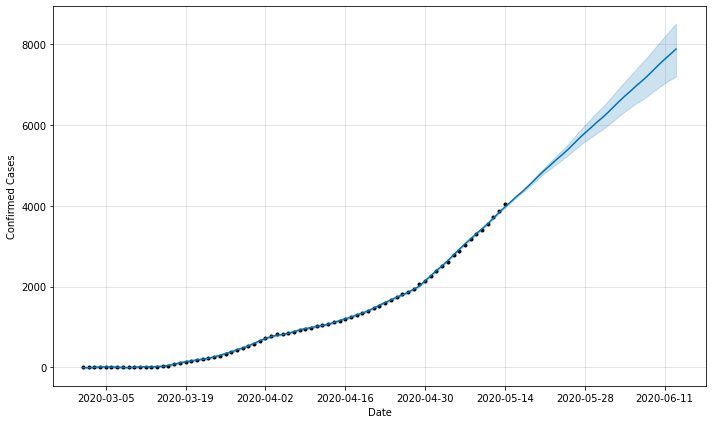

In [0]:
#Now we can plot the forecast
fig1 = m.plot(forecast, xlabel='Date', ylabel='Confirmed Cases', figsize=(10,6))


In [0]:
 #Calculate mean absolute percentage error (MAPE)"""
def calculate_mape(y_true, y_pred):
       return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#Calculate mean percentage error (MPE)"""
def calculate_mpe(y_true, y_pred):
        return np.mean((y_true - y_pred) / y_true) * 100
#Calculate mean absolute error (MAE)"""
def calculate_mae(y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred)) * 100
#Calculate root mean square error (RMSE)"""
def calculate_mse(y_true, y_pred):
       return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('MSE: %f'%calculate_mse(y_true, y_pred))
    return

In [0]:
#In general the metrics are much higher from that of ARIMA. This means that ARIMA is more reliable in terms of accuracy. 
print_error_metrics(y_true = data_['y'], y_pred = forecast['yhat'])

MAPE: 93.034996
MPE: 11.304893
MAE: 1083.030891
MSE: 16.430281


THE END!